In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib
from sklearn.feature_extraction import DictVectorizer

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stops = stopwords.words()

In [3]:
features = [
    'clean_q1_lemmatized',
    'clean_q2_lemmatized',
#     'clean_q1_lemmatized_stem',
#     'clean_q2_lemmatized_stem'
]

In [4]:
def read_data(t, features):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

In [5]:
train = read_data('train', features)#[:10000]
test = read_data('test', features)#[:10000]

In [6]:
def make_dict_features():
    from itertools import chain
    word_set = set(chain.from_iterable(train.clean_q1_lemmatized.tolist() + train.clean_q2_lemmatized.tolist() + test.clean_q1_lemmatized.tolist() + test.clean_q2_lemmatized.tolist()))
    return ['q1_' + word for word in word_set] + ['q2_' + word for word in word_set]

In [7]:
def convert_to_dict_list(corpus):
    return [{word: 1 for word in words} for words in corpus]

def map_q1q2_dict(row):
    q1 = ['q1_' + word for word in row.clean_q1_lemmatized]
    q2 = ['q2_' + word for word in row.clean_q2_lemmatized]
    return {word: 1 for word in q1 + q2}

In [8]:
vec = DictVectorizer(sparse=True)
vec.fit([{word: 1 for word in make_dict_features()}])

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [9]:
train_q1q2 = vec.transform(train.apply(map_q1q2_dict, axis=1))

In [10]:
from fastFM import sgd

fm = sgd.FMClassification(n_iter=1000, init_stdev=0.02, l2_reg_w=1, l2_reg_V=1, rank=100, step_size=0.1)
fm.fit(train_q1q2, np.where(train.is_duplicate == 0, -1, +1))

FMClassification(init_stdev=0.02, l2_reg=None, l2_reg_V=1, l2_reg_w=1,
         n_iter=1000, random_state=123, rank=100, step_size=0.1)

In [11]:
train['fm'] = fm.predict_proba(train_q1q2)

In [12]:
test['fm'] = fm.predict_proba(vec.transform(test.apply(map_q1q2_dict, axis=1)))

In [13]:
features_to_save = [
    'fm'
]

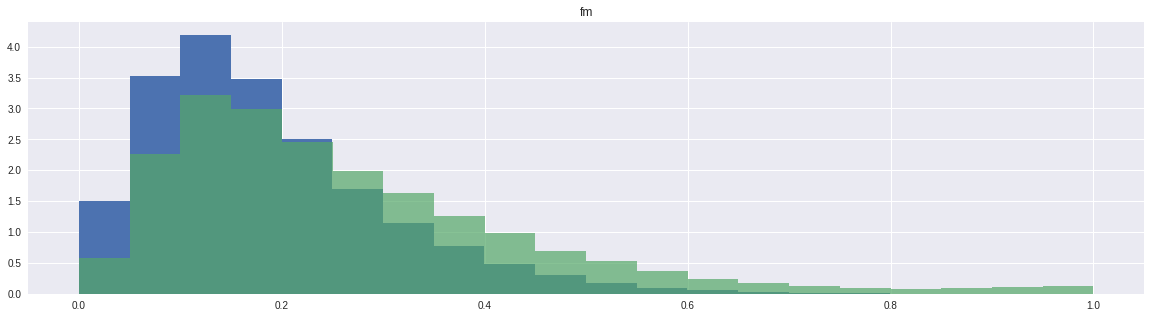

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 5.0)

for feature in features_to_save:
    plt.title(feature)
    plt.hist(train[feature][train['is_duplicate'] == 0], bins=20, normed=True, label='0')
    plt.hist(train[feature][train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
    plt.show()

In [15]:
import util
util.save_feature(train, 'train', features_to_save, 'id')
util.save_feature(test, 'test', features_to_save, 'test_id')